# Data Quality For Hungary

## 1. Date wise Mutation all Kind counts

##### In this query we extract the date wise count of mutaion kind like order_created, order_updated, order_identified & order_deleted.
##### This table contain 6 columns,<br><br> 1st column contain date which is CreatedAt date from mutation table,<br><br> 2nd column contain kind from mutation table,<br><br> 3rd column kind_overall is the table name like for order_created => order, for customer_created => customer,<br><br> 4th column action is the action created ,updated ,deleted ot identified,<br><br> 5th column frequency is count of kind on that day,<br><br> and last column banner include the banner name <br><br>
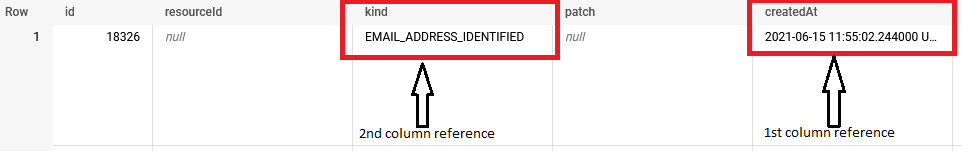

##### We have included the date control logic, in this when we run the code it will check if the output table exist or not in bigquery.<br><br> If it exist then we check max date and query will run only for those dates which are grater then max date,<br><br> and if table not exist then it will run for entire date range.

In [1]:
#Import Library
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import datetime
import time
import yaml
from datetime import date
from tqdm import tqdm
from google.cloud import bigquery
tqdm.pandas()
from io import StringIO


In [2]:
client = bigquery.Client()
print("Creating Client for (default) project: {}".format(client.project))

Creating Client for (default) project: c360-data-syndap-prod


In [3]:
def check_max_date(banner):
    query = f"""SELECT max(created_date) FROM `c360-data-spain-prod-v2.data_quality_hungary.allkind_freq_hung`
                WHERE banner='{banner}'"""
    
    df = client.query(query)
    rows = list(df)
    date = rows[0][0].date()
    return date

In [4]:
def Check_date(banner):
    try:
        max_date = check_max_date(banner)
    except:
        max_date = 0
    
    try:
        if max_date != 0:
            check_date_1 = max_date+datetime.timedelta(days=1)
        else:
            check_date_1 = 0
    except:
        check_date_1 = 0
    return check_date_1

In [5]:
banners=['ofotert_hu','grandoptical_cz','grandoptical_sk','visionexpress_hu']

In [6]:
banners_data=[]
for banner in banners:
    check_date = Check_date(banner)
        
    #print(check_date)

    if check_date == 0:
        query1 = f"""
                SELECT 
                    date(createdAt) as created_date,
                    kind,
                    REPLACE ( REPLACE( REPLACE( REPLACE( kind,'_CREATED',''),'_IDENTIFIED',''),'_UPDATED','')
                    ,'_DELETED','') as kind_overall,
                    REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE 
                    (REPLACE ( REPLACE( REPLACE( kind,'DISCOUNT_',''),'PHONE_NUMBER_',''),'ADDRESS_','')
                    ,'CONSENT_',''),'ORDER_',''),'SUBSCRIPTION_',''),'STORE_',''),'ORDER_ITEM_','')
                    ,'EMAIL_ADDRESS_',''),'PRODUCT_',''),'CUSTOMER_',''),'EMAIL_',''),'ITEM_','') as action,
                    count(distinct id) as frequency,
                    "{banner}" as banner
                 FROM `c360-data-hungary-prod.raw_{banner}.Mutation`

                group by 1, 2
                order by 1

              """
    else:
        query1 = f"""
                SELECT 
                    date(createdAt) as created_date,
                    kind,
                    REPLACE ( REPLACE( REPLACE( REPLACE( kind,'_CREATED',''),'_IDENTIFIED',''),'_UPDATED','')
                    ,'_DELETED','') as kind_overall,
                    REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE (REPLACE 
                    (REPLACE ( REPLACE( REPLACE( kind,'DISCOUNT_',''),'PHONE_NUMBER_',''),'ADDRESS_','')
                    ,'CONSENT_',''),'ORDER_',''),'SUBSCRIPTION_',''),'STORE_',''),'ORDER_ITEM_','')
                    ,'EMAIL_ADDRESS_',''),'PRODUCT_',''),'CUSTOMER_',''),'EMAIL_',''),'ITEM_','') as action,
                    count(distinct id) as frequency,
                    "{banner}" as banner
                 FROM `c360-data-hungary-prod.raw_{banner}.Mutation`
                WHERE createdAt >= '{check_date}'
                group by 1, 2
                order by 1

              """
    df1 = client.query(query1).to_dataframe()
    banners_data.append(df1)

In [7]:
banners_data_df = pd.concat(banners_data,axis=0)

##### <B>This table include date wise Mutation table kind count for all hungary banner</B>
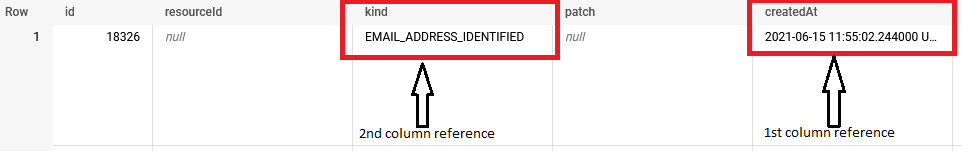

In [8]:
banners_data_df

,created_date,kind,kind_overall,action,frequency,banner
0,2021-06-15,CONSENT_IDENTIFIED,CONSENT,IDENTIFIED,5,ofotert_hu
1,2021-06-15,CUSTOMER_IDENTIFIED,CUSTOMER,IDENTIFIED,200282,ofotert_hu
2,2021-06-15,ADDRESS_IDENTIFIED,ADDRESS,IDENTIFIED,196939,ofotert_hu
3,2021-06-15,CONSENT_CREATED,CONSENT,CREATED,5,ofotert_hu
4,2021-06-15,PHONE_NUMBER_IDENTIFIED,PHONE_NUMBER,IDENTIFIED,177353,ofotert_hu
...,...,...,...,...,...,...
2492,2022-08-08,PRODUCT_CREATED,PRODUCT,CREATED,13,visionexpress_hu
2493,2022-08-08,ORDER_IDENTIFIED,ORDER,IDENTIFIED,548,visionexpress_hu
2494,2022-08-08,EMAIL_ADDRESS_DELETED,EMAIL_ADDRESS,DELETED,15,visionexpress_hu
2495,2022-08-08,DISSOCIATED,DISSOCIATED,DISSOCIATED,116,visionexpress_hu


## 2. Date wise table recourceId count check accross Mutation, Structure & Curated table

##### In this query we extract date wise resourceId count for specific table, like count of order resourceId, oreder_item resourceId accross the 3 tables mutation, structure & curated table and check the county difference between each table 

##### This table include 9 columns<br><br> 1st column contain date is CreatedAt date from mutation table<br><br> 2nd column contaion table name like order,ordrItem,customer etc.<br><br> 3rd column contain the count of resourceId for specific table from mutation table.<br><br> 4th column contain the count of resourceId for specific table from structure table.<br><br> 5th column contain the count of resourceId for specific table from curated table.<br><br> 6th column contain count differencr between mutation table & structure table.<br><br> 7th column contain count differencr between mutation table & curated table.<br><br> 8th column contain count differencr between structure table & structure table.<br><br> 9th column banner include the banner name<br><br> This query also include the date control logic.<br><br> We have consider Mutation table max date because their is one day delay in data transfer from mutation to structure table

In [9]:
def mutation_max_date(banners):
    query = f"""SELECT max(date(createdAt)) dates
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                """
    df = client.query(query)
    rows = list(df)
    date = rows[0][0]
    return date

In [10]:
def check_max_date(banner):
    query = f"""SELECT max(createdAt) FROM `c360-data-spain-prod-v2.data_quality_hungary.allkind_freq_hung`
                WHERE banner='{banner}'"""
    
    df = client.query(query)
    rows = list(df)
    date = rows[0][0].date()
    return date

In [11]:
def Check_date(banner):
    try:
        max_date = check_max_date(banner)
    except:
        max_date = 0
    
    try:
        if max_date != 0:
            check_date_1 = max_date+datetime.timedelta(days=1)
        else:
            check_date_1 = 0
    except:
        check_date_1 = 0
    return check_date_1

In [12]:
banner=['ofotert_hu','grandoptical_cz','grandoptical_sk','visionexpress_hu']

In [13]:
df=[]
for banners in banner:
    check_date = Check_date(banners)
    mutation_date = mutation_max_date(banners)
    if check_date == 0:
        query1 = f"""
                WITH
                curated_order AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) cur_order_id_count
                  FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_orders'}`
                  group by 1
                  order by 1
                  ),
                curated_orderitem AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) cur_orderitem_id_count
                  FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_order_items'}`
                  group by 1
                  order by 1
                  ),
                curated_customer AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) cur_customer_id_count
                  FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_customers'}`
                  group by 1
                  order by 1
                  ),
                curated_product AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) cur_product_id_count
                  FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_products'}`
                  group by 1
                  order by 1
                  ),
                curated_store AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) cur_store_id_count
                  FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_stores'}`
                  group by 1
                  order by 1
                  ),
                curated_discount AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) cur_discount_id_count
                  FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_discounts'}`
                  group by 1
                  order by 1
                  ),


                Structure_order AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_order_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_orders'}`
                  group by 1
                  order by 1
                  ),
                Structure_orderitem AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_orderitem_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_order_items'}`
                  group by 1
                  order by 1
                  ),
                Structure_customer AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_customer_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_customers'}`
                  group by 1
                  order by 1
                  ),
                Structure_product AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_product_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_products'}`
                  group by 1
                  order by 1
                  ),
                Structure_store AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_store_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_stores'}`
                  group by 1
                  order by 1
                  ),
                Structure_email AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_email_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_email_address_resources'}`
                  group by 1
                  order by 1
                  ),
                Structure_discount AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_discount_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_discounts'}`
                  group by 1
                  order by 1
                  ),
                Structure_phone AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_phone_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_phone_number_resources'}`
                  group by 1
                  order by 1
                  ),
                Structure_consent AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_consent_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_consent_resources'}`
                  group by 1
                  order by 1
                  ),
                Structure_address AS
                  (
                  SELECT date(createdAt) dates,count(distinct resourceId) Struc_address_id_count
                  FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_address_resources'}`
                  group by 1
                  order by 1
                  ),
                  Structure_association AS
                (
                SELECT date(createdAt) dates,count(resourceId1) association_count
                FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_associations'}`
                group by 1
                order by 1
                ),

                mutation_association AS 
                (
                SELECT date(createdAt) dates,count(distinct id) mut_asso_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='ASSOCIATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),

                mutation_order AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_order_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='ORDER_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),
                mutation_orderitem AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_orderitem_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='ORDER_ITEM_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),
                mutation_customer AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_customer_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='CUSTOMER_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),
                mutation_product AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_product_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='PRODUCT_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),
                mutation_store AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_store_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='STORE_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),
                mutation_email AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_email_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='EMAIL_ADDRESS_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),
                mutation_discount AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_discount_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='DISCOUNT_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),
                mutation_phone AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_phone_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='PHONE_NUMBER_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),
                mutation_consent AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_consent_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='CONSENT_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                ),
                mutation_address AS 
                (
                SELECT date(createdAt) dates,count(distinct resourceId) mut_address_id_count
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='ADDRESS_CREATED' and createdAt <'{mutation_date}'
                group by 1
                order by 1
                )


                (SELECT MO.dates,"order" as Kind,MO.mut_order_id_count as mutation,SO.Struc_order_id_count as structured,
                CO.cur_order_id_count as curated,
                (MO.mut_order_id_count - SO.Struc_order_id_count) as mutation_structured_difference,
                (MO.mut_order_id_count - CO.cur_order_id_count) as mutation_curated_difference,
                (SO.Struc_order_id_count - CO.cur_order_id_count) as structured_curated_difference,"{banners}" as banner
                FROM mutation_order MO
                LEFT JOIN
                  Structure_order SO
                  on MO.dates=SO.dates
                LEFT JOIN
                  curated_order CO
                  on MO.dates=CO.dates
                order by 1)

                union all

                (SELECT MOI.dates,"orderitem" as kind,MOI.mut_orderitem_id_count as mutation,SOI.Struc_orderitem_id_count as structured,
                COI.cur_orderitem_id_count as curated,
                (MOI.mut_orderitem_id_count - SOI.Struc_orderitem_id_count) as mutation_structured_difference,
                (MOI.mut_orderitem_id_count - COI.cur_orderitem_id_count) as mutation_curated_difference,
                (SOI.Struc_orderitem_id_count - COI.cur_orderitem_id_count) as structured_curated_difference,"{banners}" as banner
                FROM mutation_orderitem MOI
                LEFT JOIN
                  Structure_orderitem SOI
                  on MOI.dates=SOI.dates
                LEFT JOIN
                  curated_orderitem COI
                  on MOI.dates=COI.dates
                order by 1)

                union all

                (SELECT MC.dates,"customer" as kind,MC.mut_customer_id_count as mutation,SC.Struc_customer_id_count as structured,
                CC.cur_customer_id_count as curated,
                (MC.mut_customer_id_count - SC.Struc_customer_id_count) as mutation_structured_difference,
                (MC.mut_customer_id_count - CC.cur_customer_id_count) as mutation_curated_difference,
                (SC.Struc_customer_id_count - CC.cur_customer_id_count) as structured_curated_difference,"{banners}" as banner
                FROM mutation_customer MC
                LEFT JOIN
                  Structure_customer SC
                  on MC.dates=SC.dates
                LEFT JOIN
                  curated_customer CC
                  on MC.dates=CC.dates
                order by 1)

                union all

                (SELECT MP.dates,"product" as kind,MP.mut_product_id_count as Mutaion,SP.Struc_product_id_count as Structure,
                CP.cur_product_id_count as Curated,
                (MP.mut_product_id_count - SP.Struc_product_id_count) as M_S_diff,
                (MP.mut_product_id_count - CP.cur_product_id_count) as M_C_diff,
                (SP.Struc_product_id_count - CP.cur_product_id_count) as S_C_diff,"{banners}" as Banner
                FROM mutation_product MP
                LEFT JOIN
                  Structure_product SP
                  on MP.dates=SP.dates
                LEFT JOIN
                  curated_product CP
                  on MP.dates=CP.dates
                order by 1)

                union all

                (SELECT MS.dates,"store" as kind,MS.mut_store_id_count as mutation,SS.Struc_store_id_count as structured,
                CS.cur_store_id_count as curated,
                (MS.mut_store_id_count - SS.Struc_store_id_count) as mutation_structured_difference,
                (MS.mut_store_id_count - CS.cur_store_id_count) as mutation_curated_difference,
                (SS.Struc_store_id_count - CS.cur_store_id_count) as structured_curated_difference,"{banners}" as banner
                FROM mutation_store MS
                LEFT JOIN
                  Structure_store SS
                  on MS.dates=SS.dates
                LEFT JOIN
                  curated_store CS
                  on MS.dates=CS.dates
                order by 1)

                union all

                (SELECT ME.dates,"email" as kind,ME.mut_email_id_count as mutation,SE.Struc_email_id_count as structured,
                 0 as curated,
                 (ME.mut_email_id_count - SE.Struc_email_id_count) as mutation_structured_difference,
                 0 as mutation_curated_difference,0 as structured_curated_difference,"{banners}" as banner
                FROM mutation_email ME
                LEFT JOIN
                  Structure_email SE
                  on ME.dates=SE.dates
                order by 1)

                union all

                (SELECT MD.dates,"discount" as kind,MD.mut_discount_id_count as mutation,SD.Struc_discount_id_count as structured,
                CD.cur_discount_id_count as curated,
                (MD.mut_discount_id_count - SD.Struc_discount_id_count) as mutation_structured_difference,
                (MD.mut_discount_id_count - CD.cur_discount_id_count) as mutation_curated_difference,
                (SD.Struc_discount_id_count - CD.cur_discount_id_count) as structured_curated_difference,"{banners}" as banner
                FROM mutation_discount MD
                LEFT JOIN
                  Structure_discount SD
                  on MD.dates=SD.dates
                LEFT JOIN
                  curated_discount CD
                  on MD.dates=CD.dates
                order by 1)

                union all

                (SELECT MPn.dates,"phone" as kind,MPn.mut_phone_id_count as Mutaion,SPn.Struc_phone_id_count as Structure,
                 0 as Curated,
                 (MPn.mut_phone_id_count - SPn.Struc_phone_id_count) as M_S_diff,0 as M_C_diff,0 as S_C_diff,"{banners}" as Banner
                FROM mutation_phone MPn
                LEFT JOIN
                  Structure_phone SPn
                  on MPn.dates=SPn.dates
                order by 1)

                union all

                (SELECT MCn.dates,"consent" as kind,MCn.mut_consent_id_count as mutation,SCn.Struc_consent_id_count as structured,
                 0 as curated,
                 (MCn.mut_consent_id_count - SCn.Struc_consent_id_count) as mutation_structured_difference,
                 0 as mutation_curated_difference,0 as structured_curated_difference,"{banners}" as banner
                FROM mutation_consent MCn
                LEFT JOIN
                  Structure_consent SCn
                  on MCn.dates=SCn.dates
                order by 1)

                union all

                (SELECT MA.dates,"address" as kind,MA.mut_address_id_count as mutation,SA.Struc_address_id_count as structured,
                 0 as curated,
                 (MA.mut_address_id_count - SA.Struc_address_id_count) as mutation_structured_difference,
                 0 as mutation_curated_difference,0 as structured_curated_difference,"{banners}" as banner
                FROM mutation_address MA
                LEFT JOIN
                  Structure_address SA
                  on MA.dates=SA.dates
                order by 1)

                union all

                (SELECT MAs.dates,"association" as Kind,MAs.mut_asso_count as mutation,SAs.association_count as structured,
                0 as curated,
                (MAs.mut_asso_count - SAs.association_count) as mutation_structured_difference,
                0 as mutation_curated_difference,
                0 as structured_curated_difference,"{banners}" as banner
                FROM mutation_association MAs
                LEFT JOIN
                  Structure_association SAs
                  on MAs.dates=SAs.dates
                order by 1)

                order by 2,1   
            """
    else:
        query1 = f"""
            WITH
            curated_order AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) cur_order_id_count
              FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_orders'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            curated_orderitem AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) cur_orderitem_id_count
              FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_order_items'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            curated_customer AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) cur_customer_id_count
              FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_customers'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            curated_product AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) cur_product_id_count
              FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_products'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            curated_store AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) cur_store_id_count
              FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_stores'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            curated_discount AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) cur_discount_id_count
              FROM `{'c360-data-hungary-prod.curated_'+banners+'.cdr_discounts'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),


            Structure_order AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_order_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_orders'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            Structure_orderitem AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_orderitem_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_order_items'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            Structure_customer AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_customer_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_customers'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            Structure_product AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_product_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_products'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            Structure_store AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_store_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_stores'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            Structure_email AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_email_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_email_address_resources'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            Structure_discount AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_discount_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_discounts'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            Structure_phone AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_phone_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_phone_number_resources'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            Structure_consent AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_consent_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_consent_resources'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
            Structure_address AS
              (
              SELECT date(createdAt) dates,count(distinct resourceId) Struc_address_id_count
              FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_address_resources'}`
              WHERE createdAt >='{check_date}'
              group by 1
              order by 1
              ),
              Structure_association AS
            (
            SELECT date(createdAt) dates,count(resourceId1) association_count
            FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_associations'}`
            WHERE createdAt >='{check_date}'
            group by 1
            order by 1
            ),

            mutation_association AS 
            (
            SELECT date(createdAt) dates,count(distinct id) mut_asso_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='ASSOCIATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),

            mutation_order AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_order_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='ORDER_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),
            mutation_orderitem AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_orderitem_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='ORDER_ITEM_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),
            mutation_customer AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_customer_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='CUSTOMER_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),
            mutation_product AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_product_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='PRODUCT_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),
            mutation_store AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_store_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='STORE_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),
            mutation_email AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_email_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='EMAIL_ADDRESS_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),
            mutation_discount AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_discount_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='DISCOUNT_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),
            mutation_phone AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_phone_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='PHONE_NUMBER_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),
            mutation_consent AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_consent_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='CONSENT_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            ),
            mutation_address AS 
            (
            SELECT date(createdAt) dates,count(distinct resourceId) mut_address_id_count
            FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
            WHERE kind='ADDRESS_CREATED' and createdAt >='{check_date}' and createdAt <'{mutation_date}'
            group by 1
            order by 1
            )


            (SELECT MO.dates,"order" as Kind,MO.mut_order_id_count as mutation,SO.Struc_order_id_count as structured,
            CO.cur_order_id_count as curated,
            (MO.mut_order_id_count - SO.Struc_order_id_count) as mutation_structured_difference,
            (MO.mut_order_id_count - CO.cur_order_id_count) as mutation_curated_difference,
            (SO.Struc_order_id_count - CO.cur_order_id_count) as structured_curated_difference,"{banners}" as banner
            FROM mutation_order MO
            LEFT JOIN
              Structure_order SO
              on MO.dates=SO.dates
            LEFT JOIN
              curated_order CO
              on MO.dates=CO.dates
            order by 1)

            union all

            (SELECT MOI.dates,"orderitem" as kind,MOI.mut_orderitem_id_count as mutation,SOI.Struc_orderitem_id_count as structured,
            COI.cur_orderitem_id_count as curated,
            (MOI.mut_orderitem_id_count - SOI.Struc_orderitem_id_count) as mutation_structured_difference,
            (MOI.mut_orderitem_id_count - COI.cur_orderitem_id_count) as mutation_curated_difference,
            (SOI.Struc_orderitem_id_count - COI.cur_orderitem_id_count) as structured_curated_difference,"{banners}" as banner
            FROM mutation_orderitem MOI
            LEFT JOIN
              Structure_orderitem SOI
              on MOI.dates=SOI.dates
            LEFT JOIN
              curated_orderitem COI
              on MOI.dates=COI.dates
            order by 1)

            union all

            (SELECT MC.dates,"customer" as kind,MC.mut_customer_id_count as mutation,SC.Struc_customer_id_count as structured,
            CC.cur_customer_id_count as curated,
            (MC.mut_customer_id_count - SC.Struc_customer_id_count) as mutation_structured_difference,
            (MC.mut_customer_id_count - CC.cur_customer_id_count) as mutation_curated_difference,
            (SC.Struc_customer_id_count - CC.cur_customer_id_count) as structured_curated_difference,"{banners}" as banner
            FROM mutation_customer MC
            LEFT JOIN
              Structure_customer SC
              on MC.dates=SC.dates
            LEFT JOIN
              curated_customer CC
              on MC.dates=CC.dates
            order by 1)

            union all

            (SELECT MP.dates,"product" as kind,MP.mut_product_id_count as mutation,SP.Struc_product_id_count as structured,
            CP.cur_product_id_count as curated,
            (MP.mut_product_id_count - SP.Struc_product_id_count) as mutation_structured_difference,
            (MP.mut_product_id_count - CP.cur_product_id_count) as mutation_curated_difference,
            (SP.Struc_product_id_count - CP.cur_product_id_count) as structured_curated_difference,"{banners}" as banner
            FROM mutation_product MP
            LEFT JOIN
              Structure_product SP
              on MP.dates=SP.dates
            LEFT JOIN
              curated_product CP
              on MP.dates=CP.dates
            order by 1)

            union all

            (SELECT MS.dates,"store" as kind,MS.mut_store_id_count as mutation,SS.Struc_store_id_count as structured,
            CS.cur_store_id_count as curated,
            (MS.mut_store_id_count - SS.Struc_store_id_count) as mutation_structured_difference,
            (MS.mut_store_id_count - CS.cur_store_id_count) as mutation_curated_difference,
            (SS.Struc_store_id_count - CS.cur_store_id_count) as structured_curated_difference,"{banners}" as banner
            FROM mutation_store MS
            LEFT JOIN
              Structure_store SS
              on MS.dates=SS.dates
            LEFT JOIN
              curated_store CS
              on MS.dates=CS.dates
            order by 1)

            union all

            (SELECT ME.dates,"email" as kind,ME.mut_email_id_count as mutation,SE.Struc_email_id_count as structured,
             0 as curated,
             (ME.mut_email_id_count - SE.Struc_email_id_count) as mutation_structured_difference,
             0 as mutation_curated_difference,0 as structured_curated_difference,"{banners}" as banner
            FROM mutation_email ME
            LEFT JOIN
              Structure_email SE
              on ME.dates=SE.dates
            order by 1)

            union all

            (SELECT MD.dates,"discount" as kind,MD.mut_discount_id_count as mutation,SD.Struc_discount_id_count as structured,
            CD.cur_discount_id_count as curated,
            (MD.mut_discount_id_count - SD.Struc_discount_id_count) as mutation_structured_difference,
            (MD.mut_discount_id_count - CD.cur_discount_id_count) as mutation_curated_difference,
            (SD.Struc_discount_id_count - CD.cur_discount_id_count) as structured_curated_difference,"{banners}" as banner
            FROM mutation_discount MD
            LEFT JOIN
              Structure_discount SD
              on MD.dates=SD.dates
            LEFT JOIN
              curated_discount CD
              on MD.dates=CD.dates
            order by 1)

            union all

            (SELECT MPn.dates,"phone" as kind,MPn.mut_phone_id_count as mutation,SPn.Struc_phone_id_count as structured,
             0 as curated,
             (MPn.mut_phone_id_count - SPn.Struc_phone_id_count) as mutation_structured_difference,
             0 as mutation_curated_difference,0 as structured_curated_difference,"{banners}" as banner
            FROM mutation_phone MPn
            LEFT JOIN
              Structure_phone SPn
              on MPn.dates=SPn.dates
            order by 1)

            union all

            (SELECT MCn.dates,"consent" as kind,MCn.mut_consent_id_count as mutation,SCn.Struc_consent_id_count as structured,
             0 as curated,
             (MCn.mut_consent_id_count - SCn.Struc_consent_id_count) as mutation_structured_difference,
             0 as mutation_curated_difference,0 as structured_curated_difference,"{banners}" as banner
            FROM mutation_consent MCn
            LEFT JOIN
              Structure_consent SCn
              on MCn.dates=SCn.dates
            order by 1)

            union all

            (SELECT MA.dates,"address" as kind,MA.mut_address_id_count as mutation,SA.Struc_address_id_count as structured,
             0 as curated,
             (MA.mut_address_id_count - SA.Struc_address_id_count) as mutation_structured_difference,
             0 as mutation_curated_difference,0 as structured_curated_difference,"{banners}" as banner
            FROM mutation_address MA
            LEFT JOIN
              Structure_address SA
              on MA.dates=SA.dates
            order by 1)

            union all

            (SELECT MAs.dates,"association" as Kind,MAs.mut_asso_count as mutation,SAs.association_count as structured,
            0 as curated,
            (MAs.mut_asso_count - SAs.association_count) as mutation_structured_difference,
            0 as mutation_curated_difference,
            0 as structured_curated_difference,"{banners}" as banner
            FROM mutation_association MAs
            LEFT JOIN
              Structure_association SAs
              on MAs.dates=SAs.dates
            order by 1)

            order by 2,1   
    """
    df1 = client.query(query1).to_dataframe()
    df.append(df1)

In [14]:
data = pd.concat(df,axis=0)

In [15]:
data = data.reset_index(drop=True)

In [17]:
data

,dates,Kind,mutation,structured,curated,mutation_structured_difference,mutation_curated_difference,structured_curated_difference,banner
0,2021-11-08,address,1,1.0,0,0.0,0,0,ofotert_hu
1,2021-11-09,address,2,2.0,0,0.0,0,0,ofotert_hu
2,2021-11-10,address,239,239.0,0,0.0,0,0,ofotert_hu
3,2022-02-02,address,98520,98520.0,0,0.0,0,0,ofotert_hu
4,2022-02-03,address,114770,114770.0,0,0.0,0,0,ofotert_hu
...,...,...,...,...,...,...,...,...,...
3719,2022-08-04,product,10,10.0,10,0.0,0,0,visionexpress_hu
3720,2022-08-05,product,7,7.0,7,0.0,0,0,visionexpress_hu
3721,2022-08-06,product,11,11.0,11,0.0,0,0,visionexpress_hu
3722,2022-08-07,product,3,3.0,3,0.0,0,0,visionexpress_hu


## 3. Date wise association kind count check across Mutation & Structure table

##### In this query we extract date wise association kind count from mutaion table and check across with structure table count.

##### This table contains 7 columns<br><br> 1st column contain date is CreatedAt date from mutation table<br><br> 2nd column mutation_association_kind is association kind from mutation table <br><br>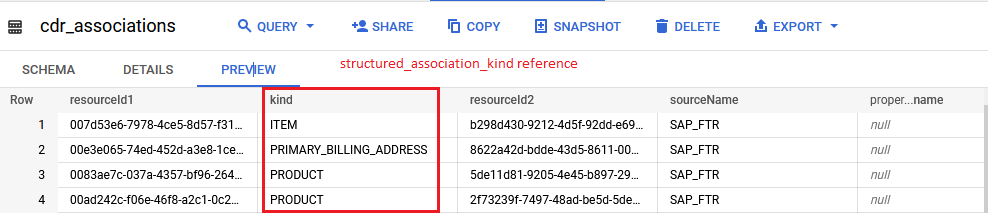<br><br> 3rd column is count of associayion kind from mutation table<br><br> 4th column is count of same association kind from structure table<br><br> 5th column structured_association_kind is association kind from structure table <br><br>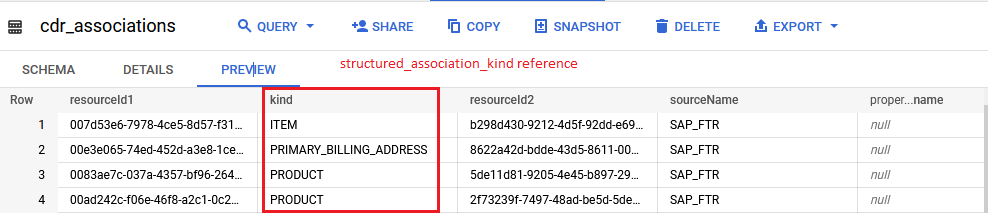<br><br> 6th column is difference between Mutation count & structure count<br><br>7th column banner include the banner name<br><br> This query also include the date control logic.<br><br> We have consider Mutation table max date because their is one day delay in data transfer from mutation to structure table

In [18]:
def mutation_max_date(banners):
    query = f"""SELECT max(date(createdAt)) dates
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                """
    df = client.query(query)
    rows = list(df)
    date = rows[0][0]
    return date

In [19]:
def check_max_date(banner):
    query = f"""SELECT max(createdAt) FROM `c360-data-spain-prod-v2.data_quality_hungary.allkind_freq_hung`
                WHERE banner='{banner}'"""
    
    df = client.query(query)
    rows = list(df)
    date = rows[0][0].date()
    return date

In [20]:
def Check_date(banner):
    try:
        max_date = check_max_date(banner)
    except:
        max_date = 0
    
    try:
        if max_date != 0:
            check_date_1 = max_date+datetime.timedelta(days=1)
        else:
            check_date_1 = 0
    except:
        check_date_1 = 0
    return check_date_1

In [21]:
banner=['ofotert_hu','grandoptical_cz','grandoptical_sk','visionexpress_hu']

In [22]:
data=[]
for banners in banner:
    check_date = Check_date(banners)
    mutation_date = mutation_max_date(banners)
    if check_date == 0:
        query = f"""
                WITH
                structure AS
                (
                SELECT date(createdAt) as dates,kind,count(*) as counts
                FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_associations'}`
                group by 1, 2
                order by 1,2
                ),
                mutation AS
                (
                SELECT dates,replace(asso_kind,'"','') as kind, count(id) as counts
                from(
                SELECT distinct id,kind,JSON_EXTRACT(association,"$.kind") asso_kind, date(createdAt) as dates
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='ASSOCIATED' and createdAt <'{mutation_date}')
                group by 1, 2
                order by 1, 2
                )

                SELECT M.dates,M.kind as mutation_association_kind,M.counts as mutation_count, S.counts as structured_count,
                S.kind as structured_association_kind,
                (M.counts-S.counts) as mutation_structured_difference,"{banners}" as banner
                FROM mutation M
                FULL OUTER JOIN
                  structure S
                  on M.dates=S.dates and M.kind=S.kind
                order by 1, 2

                """
    else:
        query = f"""
                WITH
                structure AS
                (
                SELECT date(createdAt) as dates,kind,count(*) as counts
                FROM `{'c360-data-hungary-prod.structured_'+banners+'.cdr_associations'}`
                WHERE createdAt >='{check_date}'
                group by 1, 2
                order by 1,2
                ),
                mutation AS
                (
                SELECT dates,replace(asso_kind,'"','') as kind, count(id) as counts
                from(
                SELECT distinct id,kind,JSON_EXTRACT(association,"$.kind") asso_kind, date(createdAt) as dates
                FROM `{'c360-data-hungary-prod.raw_'+banners+'.Mutation'}`
                WHERE kind='ASSOCIATED' and createdAt <'{mutation_date}' and createdAt >='{check_date}')
                group by 1, 2
                order by 1, 2
                )

                SELECT M.dates,M.kind as mutation_association_kind,M.counts as mutation_count, S.counts as structured_count,
                S.kind as structured_association_kind,
                (M.counts-S.counts) as mutation_structured_difference,"{banners}" as banner
                FROM mutation M
                FULL OUTER JOIN
                  structure S
                  on M.dates=S.dates and M.kind=S.kind
                order by 1, 2

                """
    df = client.query(query).to_dataframe()
    data.append(df)

In [23]:
dataset = pd.concat(data,axis=0)

In [24]:
dataset =dataset.reset_index(drop=True)

##### <b>None date meance we don't have CreatedAt date for few association kind in structure table</b>

In [25]:
dataset

,dates,mutation_association_kind,mutation_count,structured_count,structured_association_kind,mutation_structured_difference,banner
0,None,None,NaN,765836.0,CONSENTER,NaN,ofotert_hu
1,None,None,NaN,112.0,DISSENTER,NaN,ofotert_hu
2,None,None,NaN,112.0,DISSENT,NaN,ofotert_hu
3,None,None,NaN,765212.0,CONSENT,NaN,ofotert_hu
4,2021-06-15,ADDRESS,196937.0,196937.0,ADDRESS,0.0,ofotert_hu
...,...,...,...,...,...,...,...
7100,2022-08-07,PRIMARY_PHONE_NUMBER,205.0,205.0,PRIMARY_PHONE_NUMBER,0.0,visionexpress_hu
7101,2022-08-07,PRODUCT,2712.0,2712.0,PRODUCT,0.0,visionexpress_hu
7102,2022-08-07,STORE,771.0,771.0,STORE,0.0,visionexpress_hu
7103,2022-08-07,SUBSCRIBER,10.0,10.0,SUBSCRIBER,0.0,visionexpress_hu


## 4. Association count check with respect to resourceId (For Structure Association Table)

##### In this query we check date wise resourceId created for each table and check all the association avilable or not for each resourceId. We are checking for each single resourceId, if association avilable then we count it in "available_associations" & if association not avilable then we count it in "missing_associations". This association count check with respect to resourceId is between structure Association table and all structute table

##### This table contains 8 columns<br><br> 1st column is table name from curated table(resourceId1 from association table). <br><br> 2nd column is association column (resourceId2 from association table).<br><br>   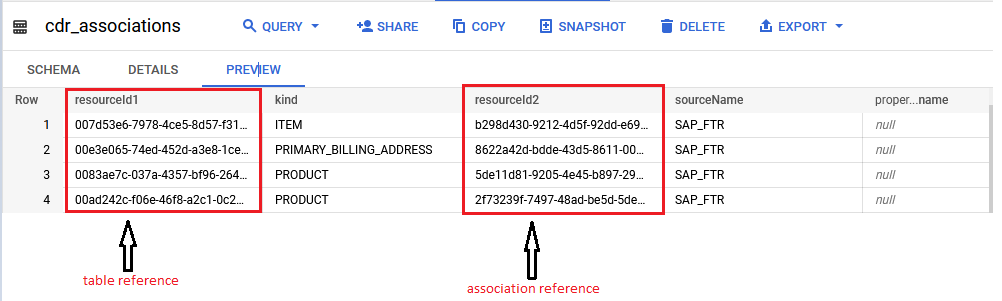<br><br> 3rd column is total record which define total number of resourceId for specific table. <br><br> 4th column is available_associations count between table & association.<br><br> 5th column is missing_associations count between table & association.<br><br> 6th column is check_date taken from CreatedAt column from structure table<br><br> This query also include the date control logic.<br><br> We have consider Mutation table max date because their is one day delay in data transfer from mutation to structure table

In [27]:
#access YAML files for configuration
with open('data_association_config.yml') as file:
    confg_data= yaml.safe_load(file)

In [28]:
banners = confg_data['banners']

In [29]:
# list of table & table association
table_association = confg_data['table_association']

In [30]:
def check_max_date(banner):
    query = f"""SELECT max(check_date) FROM `{confg_data['dest_project']+"."+confg_data['dest_dataset']+"."+confg_data['dest_table']}`
                WHERE banner='{banner}'"""
    
    df = client.query(query)
    rows = list(df)
    date = rows[0][0].date()
    return date

In [31]:
def Check_date(banner):
    try:
        max_date = check_max_date(banner)
    except:
        max_date = 0
    
    try:
        if max_date != 0:
            check_date_1 = max_date+datetime.timedelta(days=1)
        else:
            check_date_1 = 0
    except:
        check_date_1 = 0
    return check_date_1

In [32]:
data_quality_list = []

In [33]:
def query_extract(table, association,banner):
    check_date = Check_date(banners)
    
    if check_date == 0:
    
        query = f"""
            SELECT date(createdAt) as check_date,"{table}" as table,"{association}" as association,
            COUNT(resourceId) as total_records,
            COUNTIF(a.kind IS NOT NULL) as available_associations,
            COUNTIF(a.kind IS NULL) as missing_associations,
            (select distinct max(sourceName) from `{confg_data['project']+".structured_"+banner+"."+table}` LIMIT 1) as SourceID,
            "{banner}" as banner
            FROM
            (SELECT
            DISTINCT resourceId, createdAt
            FROM
            `{confg_data['project']+".structured_"+banner+"."+table}`

            )m
            LEFT OUTER JOIN
            (SELECT DISTINCT kind, resourceId1
            FROM
            `{confg_data['project']+".structured_"+banner+"."+'cdr_associations'}`
            WHERE kind = '{association}') a
            ON m.resourceId = a.resourceId1 
            group by 1,3
            order by 1
            """
        try:
            df1 = client.query(query).to_dataframe()

        except:
            df1['check_date']=check_date
            df1['table']=table
            df1['association']=association
            df1['total_records']=0
            df1['available_associations']=0
            df1['missing_associations']=0
            df1['SourceID']="NAN"
            df1['banner']=banner
    else:
        query = f"""
            SELECT date(createdAt) as check_date,"{table}" as table,"{association}" as association,
            COUNT(resourceId) as total_records,
            COUNTIF(a.kind IS NOT NULL) as available_associations,
            COUNTIF(a.kind IS NULL) as missing_associations,
            (select distinct max(sourceName) from `{confg_data['project']+".structured_"+banner+"."+table}` LIMIT 1) as SourceID,
            "{banner}" as banner
            FROM
            (SELECT
            DISTINCT resourceId, createdAt
            FROM
            `{confg_data['project']+".structured_"+banner+"."+table}`
            WHERE createdAt >= '{check_date}'
            )m
            LEFT OUTER JOIN
            (SELECT DISTINCT kind, resourceId1
            FROM
            `{confg_data['project']+".structured_"+banner+"."+'cdr_associations'}`
            WHERE kind = '{association}') a
            ON m.resourceId = a.resourceId1 
            group by 1,3
            order by 1
            """
        try:
            df1 = client.query(query).to_dataframe()

        except:
            df1['check_date']=check_date
            df1['table']=table
            df1['association']=association
            df1['total_records']=0
            df1['available_associations']=0
            df1['missing_associations']=0
            df1['SourceID']="NAN"
            df1['banner']=banner
        
        
    return df1

In [34]:
for banner in banners:
    print(banner)
    for table in table_association:
        #print(table)
        for association in table_association[table]:
            #print(association)
            data_quality_list.append(query_extract(table, association,banner))

ofotert_hu
grandoptical_cz
grandoptical_sk
visionexpress_hu


In [35]:
structured_data_quality_df=pd.concat(data_quality_list,axis=0) 
structured_data_quality_df = structured_data_quality_df[['table','association','total_records','available_associations','missing_associations','check_date','SourceID','banner']]
structured_data_quality_df = structured_data_quality_df.astype(confg_data['destination_dataset'])
structured_data_quality_df = structured_data_quality_df.sort_values(by=['banner','check_date','table','association'])
structured_data_quality_df.reset_index(inplace=True,drop=True)
structured_data_quality_df

,table,association,total_records,available_associations,missing_associations,check_date,SourceID,banner
0,cdr_consent_resources,CONSENTER,5,3,2,2021-06-15,c360-core,grandoptical_cz
1,cdr_consent_resources,DISSENTER,5,3,2,2021-06-15,c360-core,grandoptical_cz
2,cdr_customers,ADDRESS,56821,54210,2611,2021-06-15,Synergie,grandoptical_cz
3,cdr_customers,CONSENT,56821,52593,4228,2021-06-15,Synergie,grandoptical_cz
4,cdr_customers,DISSENT,56821,36330,20491,2021-06-15,Synergie,grandoptical_cz
...,...,...,...,...,...,...,...,...
7212,cdr_order_items,ORDER,2854,2683,171,2022-08-07,SAP_FTR,visionexpress_hu
7213,cdr_order_items,PRODUCT,2854,2676,178,2022-08-07,SAP_FTR,visionexpress_hu
7214,cdr_orders,CUSTOMER,800,759,41,2022-08-07,SAP_FTR,visionexpress_hu
7215,cdr_orders,ITEM,800,793,7,2022-08-07,SAP_FTR,visionexpress_hu


## 5. Association count check with respect to resourceId (For Mutation Association Table)

##### In this query we check date wise resourceId created for each table and check all the association avilable or not for each resourceId. We are checking for each single resourceId, if association avilable then we count it in "available_associations" & if association not avilable then we count it in "missing_associations".<br><br> This association count check with respect to resourceId is between Mutation Association table and all structute table<br><br> We have created a seperate temp Association table from mutation table to check counts.<br><br> 

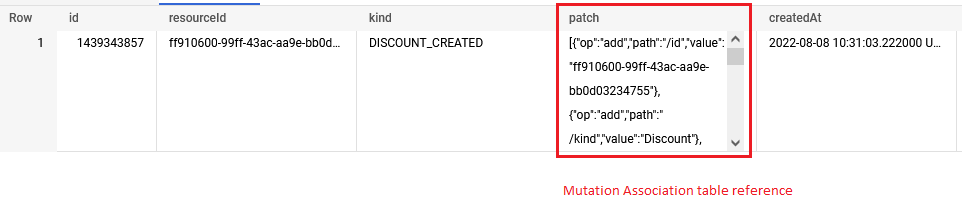

In [36]:
#access YAML files for configuration
with open('data_association_config.yml') as file:
    confg_data= yaml.safe_load(file)

In [37]:
banners = confg_data['banners']

In [38]:
# list of table & table association
table_association = confg_data['table_association']

In [39]:
def check_max_date(banner):
    query = f"""SELECT max(check_date) FROM `{confg_data['dest_project']+"."+confg_data['dest_dataset']+"."+confg_data['dest_table']}`
                WHERE banner='{banner}'"""
    
    df = client.query(query)
    rows = list(df)
    date = rows[0][0].date()
    return date

In [40]:
def Check_date(banner):
    try:
        max_date = check_max_date(banner)
    except:
        max_date = 0
    
    try:
        if max_date != 0:
            check_date_1 = max_date+datetime.timedelta(days=1)
        else:
            check_date_1 = 0
    except:
        check_date_1 = 0
    return check_date_1

In [41]:
data_quality_list = []

In [42]:
def query_extract(table, association,banner):
    check_date = Check_date(banners)
    if check_date == 0:
    
        query = f"""
            WITH
            mutation as
            (
              SELECT * FROM(
              SELECT id,replace(id1,'"','') as resourceId1,replace(kind,'"','') as kind,replace(id2,'"','') as resourceId2,createdAt
              FROM
                  (
                  SELECT 
                    distinct id,
                    JSON_EXTRACT(association,"$.id1") id1,
                    JSON_EXTRACT(association,"$.kind") kind,
                    JSON_EXTRACT(association,"$.id2") id2,
                    date(createdAt) as createdAt
                  FROM `{'c360-data-hungary-prod.raw_'+banner+'.Mutation'}`
                  WHERE kind='ASSOCIATED'
                  ))
            )


            SELECT date(createdAt) as check_date,"{table}" as table,"{association}" as association,
            COUNT(resourceId) as total_records,
            COUNTIF(a.kind IS NOT NULL) as available_associations,
            COUNTIF(a.kind IS NULL) as missing_associations,
            (select distinct max(sourceName) from `{confg_data['project']+".structured_"+banner+"."+table}` LIMIT 1) as SourceID,
            "{banner}" as banner
            FROM
            (SELECT
            DISTINCT resourceId,createdAt
            FROM
            `{confg_data['project']+".structured_"+banner+"."+table}`
            )m
            LEFT OUTER JOIN
            (SELECT DISTINCT kind, resourceId1
            FROM mutation
            WHERE kind = '{association}') a
            ON m.resourceId = a.resourceId1 
            group by 1,2,3
            order by 1,2,3
            """
        try:
            df1 = client.query(query).to_dataframe()

        except:
            df1['check_date']=check_date
            df1['table']=table
            df1['association']=association
            df1['total_records']=0
            df1['available_associations']=0
            df1['missing_associations']=0
            df1['SourceID']="NAN"
    else:
        query = f"""
            WITH
            mutation as
            (
              SELECT * FROM(
              SELECT id,replace(id1,'"','') as resourceId1,replace(kind,'"','') as kind,replace(id2,'"','') as resourceId2,createdAt
              FROM
                  (
                  SELECT 
                    distinct id,
                    JSON_EXTRACT(association,"$.id1") id1,
                    JSON_EXTRACT(association,"$.kind") kind,
                    JSON_EXTRACT(association,"$.id2") id2,
                    date(createdAt) as createdAt
                  FROM `{'c360-data-hungary-prod.raw_'+banner+'.Mutation'}`
                  WHERE kind='ASSOCIATED'
                  ))
            )


            SELECT date(createdAt) as check_date,"{table}" as table,"{association}" as association,
            COUNT(resourceId) as total_records,
            COUNTIF(a.kind IS NOT NULL) as available_associations,
            COUNTIF(a.kind IS NULL) as missing_associations,
            (select distinct max(sourceName) from `{confg_data['project']+".structured_"+banner+"."+table}` LIMIT 1) as SourceID,
            "{banner}" as banner
            FROM
            (SELECT
            DISTINCT resourceId,createdAt
            FROM
            `{confg_data['project']+".structured_"+banner+"."+table}`
            WHERE createdAt >= '{check_date}'
            )m
            LEFT OUTER JOIN
            (SELECT DISTINCT kind, resourceId1
            FROM mutation
            WHERE kind = '{association}') a
            ON m.resourceId = a.resourceId1 
            group by 1,2,3
            order by 1,2,3
            """
        try:
            df1 = client.query(query).to_dataframe()

        except:
            df1['check_date']=check_date
            df1['table']=table
            df1['association']=association
            df1['total_records']=0
            df1['available_associations']=0
            df1['missing_associations']=0
            df1['SourceID']="NAN"
            df1['banner']=banner
        
        
    return df1

In [43]:
for banner in banners:
    print(banner)
    for table in table_association:
        #print(table)
        for association in table_association[table]:
            #print(association)
            data_quality_list.append(query_extract(table, association,banner))

ofotert_hu
grandoptical_cz
grandoptical_sk
visionexpress_hu


In [44]:
mutation_data_quality_df=pd.concat(data_quality_list,axis=0) 
mutation_data_quality_df = mutation_data_quality_df[['table','association','total_records','available_associations','missing_associations','check_date','SourceID','banner']]
mutation_data_quality_df = mutation_data_quality_df.astype(confg_data['destination_dataset'])
mutation_data_quality_df = mutation_data_quality_df.sort_values(by=['banner','check_date','table','association'])
mutation_data_quality_df.reset_index(inplace=True,drop=True)
mutation_data_quality_df

,table,association,total_records,available_associations,missing_associations,check_date,SourceID,banner
0,cdr_consent_resources,CONSENTER,5,3,2,2021-06-15,c360-core,grandoptical_cz
1,cdr_consent_resources,DISSENTER,5,3,2,2021-06-15,c360-core,grandoptical_cz
2,cdr_customers,ADDRESS,56821,54210,2611,2021-06-15,Synergie,grandoptical_cz
3,cdr_customers,CONSENT,56821,52592,4229,2021-06-15,Synergie,grandoptical_cz
4,cdr_customers,DISSENT,56821,36330,20491,2021-06-15,Synergie,grandoptical_cz
...,...,...,...,...,...,...,...,...
7212,cdr_order_items,ORDER,2854,2683,171,2022-08-07,SAP_FTR,visionexpress_hu
7213,cdr_order_items,PRODUCT,2854,2676,178,2022-08-07,SAP_FTR,visionexpress_hu
7214,cdr_orders,CUSTOMER,800,759,41,2022-08-07,SAP_FTR,visionexpress_hu
7215,cdr_orders,ITEM,800,793,7,2022-08-07,SAP_FTR,visionexpress_hu


## 6. ResourceId created missing Count Check for all banners table

##### In this query we check for which table resourceId created kind is missing but they have updated kind in mutation table, ex. for find customer resourceId for which customer_updated kind is available but customer_created kind is missing in mutation table.

##### This query contain two table.<br><br>
##### 1st table contains all resourceId, table name & banner name<br><br> 1st column contain resourceId for with updated kind is available but created kind is missing.<br><br> 2nd column is contain None value because of missing created kind in mutation table. <br><br> 3rd column kind contains table name<br><br> 4th column contains banner name<br><br>


##### 2nd table contaion banner, table and missing counts<br><br> 1st column contains banner name.<br><br> 2nd column kind contains table name<br><br> 3rd column contains updated id counts for which created kind is missing


In [46]:
banners=['ofotert_hu','grandoptical_cz','grandoptical_sk','visionexpress_hu']

In [47]:
kinds = ['CUSTOMER','ORDER','ORDER_ITEM','PRODUCT','STORE','PHONE_NUMBER','EMAIL_ADDRESS','ADDRESS','DISCOUNT','CONSENT']

In [48]:
data = []
for banner in banners:
    for kind in kinds:
        query = f"""

                WITH
                created as 
                (
                SELECT distinct resourceId 
                FROM `{'c360-data-hungary-prod.raw_'+banner+'.Mutation'}`
                WHERE kind = "{kind+'_CREATED'}"
                ),
                updated as 
                (
                SELECT distinct resourceId 
                FROM `{'c360-data-hungary-prod.raw_'+banner+'.Mutation'}`
                WHERE kind in ("{kind+'_UPDATED'}","{kind+'_CREATED'}")
                )

                SELECT updat_id as updated_id,creat_id as created_id
                FROM
                (
                SELECT updat_id,creat_id,
                CASE WHEN creat_id is null then 'Y'
                WHEN creat_id is not null then 'N'
                END AS buckets
                FROM (
                SELECT C.resourceId as creat_id ,U.resourceId as updat_id
                FROM created C
                right OUTER JOIN updated U
                on C.resourceId = U.resourceId)
                )
                where buckets ='Y'
                """
        df = client.query(query).to_dataframe()
        df['kind']=kind
        df['banner']=banner
        data.append(df)

In [49]:
dataset=pd.concat(data,axis=0) 
dataset.reset_index(inplace=True,drop=True)
dataset

,updated_id,created_id,kind,banner
0,63cf5bc3-2482-4773-8fc2-d027ad66e0a9,None,CUSTOMER,ofotert_hu
1,65963d49-5b51-4b78-bdda-176ce50e6f25,None,CUSTOMER,ofotert_hu
2,434c8c9b-aac1-48aa-ad46-406358b54ba3,None,CUSTOMER,ofotert_hu
3,7d623319-a6cb-4823-94d6-489b6f9b0947,None,CUSTOMER,ofotert_hu
4,9b163a3b-9ebe-49af-a346-bab418d0260a,None,CUSTOMER,ofotert_hu
...,...,...,...,...
9327,748fb273-f262-4a6e-8297-0f8a870fe2b7,None,ADDRESS,visionexpress_hu
9328,7959b777-bc79-4610-ae8f-69982adbd7f3,None,ADDRESS,visionexpress_hu
9329,f04bc579-e359-4671-bbd6-b63f00b776be,None,ADDRESS,visionexpress_hu
9330,a129f588-1a48-403d-921f-7a2b4f840e17,None,ADDRESS,visionexpress_hu


In [50]:
banner_wise_data =dataset.groupby(['banner','kind'])['updated_id'].count().reset_index()
banner_wise_data.columns=['banner', 'kind', 'updated_id_counts']
banner_wise_data

,banner,kind,updated_id_counts
0,grandoptical_cz,ADDRESS,5
1,grandoptical_cz,CUSTOMER,1777
2,grandoptical_cz,EMAIL_ADDRESS,2
3,grandoptical_cz,PHONE_NUMBER,3
4,ofotert_hu,ADDRESS,19
5,ofotert_hu,CUSTOMER,971
6,ofotert_hu,EMAIL_ADDRESS,3
7,ofotert_hu,PHONE_NUMBER,6
8,ofotert_hu,PRODUCT,2
9,visionexpress_hu,ADDRESS,43


## 7. Customer Derived Prop Missing value

##### In this query we have calculated column wise null value count and percentage with data type 
##### This table contains 4 columns<br><br> 1st column contains columns name.<br><br> 2nd column contains null value count.<br><br> 3rd column contais percentage of null value.<br><br> 4th column contains column data type

In [51]:
with open('derived_prop_config.yml') as file:
    confg_data= yaml.safe_load(file)

In [52]:
query = f""" SELECT distinct * 
            FROM `c360-data-hungary-prod.curated_ofotert_hu.cdr_derived_props_customer`
        """
df = client.query(query).to_dataframe()

In [53]:
df = df.astype(confg_data['cdr_derived_props_customer'])

In [56]:
null_data =pd.DataFrame(zip(df.isnull().sum(),round(df.isnull().sum()/df.shape[0]*100,1)), columns=["Total Null Value","Total Null Value in %"],index=df.columns).reset_index()
null_data.columns=['column','Total Null Value','Total Null Value in %']
df_dtype=df.dtypes.reset_index()
df_dtype.columns=['column','dtype']
null_value_data = null_data.merge(df_dtype,on='column',how='left')
null_value_data=null_value_data.sort_values(by=['Total Null Value in %'],ascending=False).reset_index(drop=True)
null_value_data

,column,Total Null Value,Total Null Value in %,dtype
0,dateLastPurchaseEcom,1377056,100.0,"datetime64[ns, UTC]"
1,dateFirstSubscriptionPurchaseContacts,1350448,98.0,"datetime64[ns, UTC]"
2,dateLastOrderPromoDIA,1304876,94.7,"datetime64[ns, UTC]"
3,salesAveragePurchaseContacts,1300730,94.4,float64
4,dateLastPurchaseContacts,1300612,94.4,"datetime64[ns, UTC]"
5,dateLastStoreOrderContacts,1300730,94.4,"datetime64[ns, UTC]"
6,salesLastPurchaseContactsStoreId,1300730,94.4,object
7,salesAverageNetPurchaseContacts,1300730,94.4,float64
8,dateFirstStoreOrderContacts,1300730,94.4,"datetime64[ns, UTC]"
9,dateFirstPurchaseContacts,1284172,93.2,"datetime64[ns, UTC]"


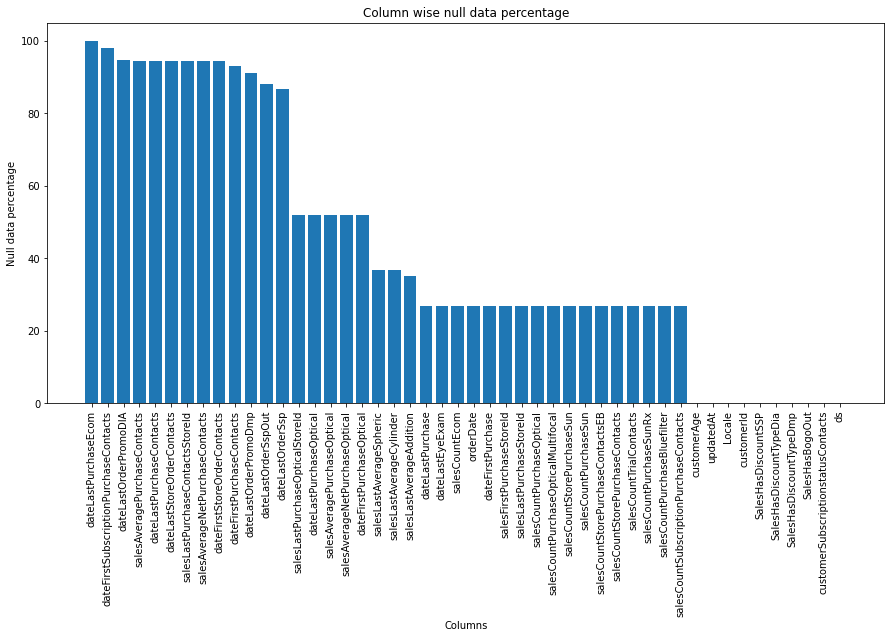

In [58]:
X=null_value_data['column']
Y=null_value_data['Total Null Value in %']
plt.figure(figsize=(15, 7))
plt.bar(X, Y)
plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Null data percentage")
plt.title("Column wise null data percentage")
plt.savefig("Column_wise_null_data_percentage.jpg")
plt.show()

## 8. Customer Derived Prop Data Profiling

#### Data Profiling contains 3 steps<br><br>1. Data Profiling<br><br>2. Numeric Data distribution<br><br>3. Bucket Creating

### 1. Data Profiling

##### In data profiling, depending on column data type we are calculating the information.<br>
##### As we have 4 data types in tables<br><br>1.Numerical<br><br>2.Categorical<br><br>3.Boolean<br><br>4.Datetime<br>
##### 1. Numerical - For Numerical data type columns we are calculating<br><br>-min<br>-median<br>-mean<br>-max<br>-total recordes<br>-null values<br>
##### 2. Categorical - For Categorical data type columns we are calculating <br><br>-total recordes<br>-null values<br>
##### 3. Boolean - For Boolean data type columns we are calculating <br><br>-Yes & No Counts<br>-total records<br>
##### 3. Datetime - For Datetime data type columns we are calculating <br><br>-total recordes<br>-null values<br><br>
##### We use date control logic in the query and used updated date for reference

In [61]:
with open('derived_prop_config.yml') as file:
    confg_data= yaml.safe_load(file)

### Initial Assigning

In [62]:
cdr_table = confg_data['cdr_table']

In [63]:
query=f"""
    SELECT min(date(updatedAt)) as min_date,
    max(date(updatedAt)) as max_date 
    FROM `c360-data-hungary-prod.curated_ofotert_hu.cdr_derived_props_customer`
        """
df = client.query(query).to_dataframe()

In [75]:
check_date = str(df['min_date'][0])
current_date = str(df['max_date'][0])

In [76]:
#Getting max date from YAML file

def check_max_date():
    query = f"""SELECT max(date) FROM `{confg_data['project']+"."
            +confg_data['destination_dataset']+"."+confg_data['destination_profiling_table']}`"""
    
    df = client.query(query)
    rows = list(df)
    date = rows[0][0].date()
    return date

In [77]:
try:
    client.get_table(confg_data['project']+"."+confg_data['destination_dataset']+"."+confg_data['destination_profiling_table'])
    print("Table already exists.")
    try:
        max_date = check_max_date()
    except:
        max_date = 0
except:
    print("Table not exists")

Table not exists


In [78]:
# if max date is non zero then change the check date with one day after max date
try:
    if max_date != 0:
        check_date = max_date+datetime.timedelta(days=1)
except:
    print("Max date is not define")

Max date is not define


In [79]:
numeric_data_profiling_list = []
object_data_profiling_list = []
bool_data_profiling_list = []
date_data_profiling_list = []

In [80]:
date_range = pd.date_range(start=check_date,end=current_date)

In [81]:
date_range

DatetimeIndex(['2022-08-08'], dtype='datetime64[ns]', freq='D')

### Function

#### Numeric column check

In [82]:
#Creating measures for numerical columns i.e quantiles, mean, median etc.

def numeric_col_check(df,table,date):
    float_list = df.select_dtypes('float64').columns.to_list()
    date = pd.to_datetime(date).date()
    df1 = df[float_list]
    data_table = []
    #data = pd.DataFrame()
    for column in df1:
        data = {'table':table,'column':column,'date':date,'data_type':'float64',
               'min':df1[column].min(),'median':df1[column].median(),
               'mean':df1[column].mean(),'max':df1[column].max(),
                'total records':df1[column].shape[0],'null values':df1[column].isna().sum()}
            

        data_table.append(data)
    data_table1 = pd.DataFrame(data_table)
    return data_table1

#### Bool column check

In [84]:
#Trying to make all bool columns uniform and then computing counts of categories

def bool_col_check(df,table,date):
    bool_list = df.select_dtypes('bool').columns.to_list()
    date = pd.to_datetime(date).date()
    df1 = df[bool_list]
    data_table = []
    for column in df1:
   
        try:
            a = df1[column].value_counts().reset_index().iloc[0][0]
             
        except:
            a = 'No'
        try:
            c = df1[column].value_counts().reset_index().iloc[0][1]
        except:
            c = 0

        data = {'table':table,'column':column,'date':date,'data_type':'bool','measure':a,'value':c}
                
        data_table.append(data)        
                
        try:
            b = df1[column].value_counts().reset_index().iloc[1][0]
            
        except:
            b = 'Yes'
        try:
            d = df1[column].value_counts().reset_index().iloc[1][1]
        except:
            d = 0

        data = {'table':table,'column':column,'date':date,'data_type':'bool','measure':b,'value':d}
        data_table.append(data)
        data = {'table':table,'column':column,'date':date,'data_type':'bool',
                'measure':'total records','value':df1[column].shape[0]}
                
        data_table.append(data)
    data_table1 = pd.DataFrame(data_table) 
    return data_table1

#### Categorical column check

In [85]:
#Counting total data points and null values in each object column type

def object_col_check(df,table,date):
    object_list = df.select_dtypes('object').columns.to_list()
    date = pd.to_datetime(date).date()
    df1 = df[object_list]
    data_table = []
    for column in df1:
        data = {'table':table,'column':column,'date':date,'data_type':'object',
       'total records':df1[column].shape[0],'null values':df1[column].isna().sum()}
        
        data_table.append(data)

    data_table1 = pd.DataFrame(data_table)
    return data_table1

#### Date column check

In [86]:
#Doing the same as above for date columns

def date_col_check(df,table,date):
    datetime_list = df.select_dtypes(include=['datetime64[ns, UTC]','datetime64[ns]']).columns.to_list()
    #datetime_list1 = df.select_dtypes('datetime64[ns, UTC]').columns.to_list()
    date = pd.to_datetime(date).date()
    df1 = df[datetime_list]
    data_table = []
    for column in df1:
        
        data = {'table':table,'column':column,'date':date,'data_type':'datetime64',
       'total records':df1[column].shape[0],'null values':df1[column].isna().sum()}
        
        data_table.append(data)

    data_table1 = pd.DataFrame(data_table)
    return data_table1


#### Query extract

In [87]:
#Function to match table with defined data types and date range 

def query_extract(table, check_date):
    end_date = check_date+datetime.timedelta(days=1)
    query = f"""SELECT * FROM `{confg_data['project']+"."+confg_data['database']+"."+table}`
            where updatedAt < '{end_date}' and updatedAt >= '{check_date}'; """
    df = client.query(query).to_dataframe()
    if table == 'cdr_derived_props_customer':
        df = df.astype(confg_data['cdr_derived_props_customer'])
    
    

    numeric_table = numeric_col_check(df,table,check_date)
    bool_table = bool_col_check(df,table,check_date)
    object_table = object_col_check(df,table,check_date)
    date_table = date_col_check(df,table,check_date)
   
    return numeric_table, bool_table, object_table, date_table

#### Getting All Dataframe

In [88]:
#Creating lists to then append into table

for date in date_range:
    print(date)
    for table in cdr_table:
        numeric_table, bool_table, object_table, date_table = query_extract(table, date)
        numeric_data_profiling_list.append(numeric_table)
        bool_data_profiling_list.append(bool_table)
        object_data_profiling_list.append(object_table)
        date_data_profiling_list.append(date_table)
        
numeric_data_profiling_df=pd.concat(numeric_data_profiling_list,axis=0)
object_data_profiling_df=pd.concat(object_data_profiling_list,axis=0)
bool_data_profiling_df=pd.concat(bool_data_profiling_list,axis=0)
date_data_profiling_df=pd.concat(date_data_profiling_list,axis=0)

2022-08-08 00:00:00


In [89]:
numeric_data_profiling_df.reset_index(inplace=True,drop=True)
object_data_profiling_df.reset_index(inplace=True,drop=True)
bool_data_profiling_df.reset_index(inplace=True,drop=True)
date_data_profiling_df.reset_index(inplace=True,drop=True)

In [90]:
numeric_data =pd.melt(numeric_data_profiling_df, id_vars =['table', 'column',
                                                           'date','data_type'], value_vars =['min', 'median', 
                                                                                             'mean', 'max', 'total records',
                                                                                             'null values'])

In [91]:
numeric_data.columns = ['table', 'column', 'date','data_type','measure', 'value']
numeric_data = numeric_data.sort_values(by=['date','table','column','measure'])
numeric_data.reset_index(inplace=True,drop=True)

In [92]:
numeric_data = numeric_data.astype(confg_data['profiling_dataset'])

In [93]:
object_data =pd.melt(object_data_profiling_df, id_vars = ['table', 'column',
                                                           'date','data_type'], value_vars=['total records','null values'])

In [94]:
object_data.columns = ['table', 'column', 'date','data_type','measure', 'value']
object_data = object_data.sort_values(by=['date','table','column','measure'])
object_data.reset_index(inplace=True,drop=True)

In [95]:
object_data = object_data.astype(confg_data['profiling_dataset'])

In [96]:
bool_data_profiling_df = bool_data_profiling_df.astype(confg_data['profiling_dataset'])

In [97]:
bool_data_profiling_df.loc[bool_data_profiling_df['measure']==True, 'measure']='Yes'
bool_data_profiling_df.loc[bool_data_profiling_df['measure']==False, 'measure']='No'

In [98]:
date_data =pd.melt(date_data_profiling_df, id_vars = ['table', 'column',
                                                           'date','data_type'], value_vars=['total records','null values'])

In [99]:
date_data.columns = ['table', 'column', 'date','data_type','measure', 'value']
date_data = date_data.sort_values(by=['date','table','column','measure'])
date_data.reset_index(inplace=True,drop=True)

In [100]:
date_data = date_data.astype(confg_data['profiling_dataset'])

In [101]:
profiling_data = pd.concat([numeric_data,object_data,bool_data_profiling_df,date_data],axis=0)

In [102]:
profiling_data.reset_index(inplace=True,drop=True)
profiling_data = profiling_data.round(2)
profiling_data

,table,column,date,data_type,measure,value
0,cdr_derived_props_customer,customerAge,2022-08-08,float64,max,188.00
1,cdr_derived_props_customer,customerAge,2022-08-08,float64,mean,51.59
2,cdr_derived_props_customer,customerAge,2022-08-08,float64,median,52.00
3,cdr_derived_props_customer,customerAge,2022-08-08,float64,min,0.00
4,cdr_derived_props_customer,customerAge,2022-08-08,float64,null values,1047.00
...,...,...,...,...,...,...
172,cdr_derived_props_customer,ds,2022-08-08,datetime64,total records,1377518.00
173,cdr_derived_props_customer,orderDate,2022-08-08,datetime64,null values,370610.00
174,cdr_derived_props_customer,orderDate,2022-08-08,datetime64,total records,1377518.00
175,cdr_derived_props_customer,updatedAt,2022-08-08,datetime64,null values,0.00


## 9. Bucket Creating for Numerical Data (Customer Derived Prop)

##### For numerical columns we have to create the histogram distibution for that 1st we have to create bins so that they have equal distribution every time when we do histogram.
##### We have created the bins on all data

In [103]:
with open('derived_prop_config.yml') as file:
    confg_data= yaml.safe_load(file)

In [104]:
cdr_table = confg_data['cdr_table']

In [105]:
query=f"""
    SELECT min(date(updatedAt)) as min_date,
    max(date(updatedAt)) as max_date 
    FROM `c360-data-hungary-prod.curated_ofotert_hu.cdr_derived_props_customer`
        """
df = client.query(query).to_dataframe()

In [106]:
check_date = str(df['min_date'][0])
current_date = str(df['max_date'][0])

In [107]:
check_date = pd.to_datetime(check_date)
current_date = pd.to_datetime(current_date)

### Function

#### Bins data function

In [108]:
def bins_data(column,table,check_date,current_date):
    query = f"""SELECT min({column}) as min,max({column}) as max,
    (select percentiles_1[offset(98)], from(SELECT APPROX_QUANTILES({column}, 100) percentiles_1, 
    FROM `{confg_data['project']+"."+confg_data['database']+"."+table}` 
    where updatedAt <= '{current_date}' and updatedAt >= '{check_date}'))  as data_98,
    FROM `{confg_data['project']+"."+confg_data['database']+"."+table}`
    where updatedAt <= '{current_date}' and updatedAt >= '{check_date}'; """
    df = client.query(query).to_dataframe()
    df['table'] = table
    df['column'] = column
    
    return df

#### Numeric column check function

In [110]:
def numeric_col_check(df,table,check_date,current_date):
    float_list = df.select_dtypes('float64').columns.to_list()
    df1 = df[float_list]
    data_bins= []
    for column in df1:
        bins_df = bins_data(column,table,check_date,current_date)  
        data_bins.append(bins_df)
        
    return data_bins

#### Query extract function

In [111]:
def query_extract(table, check_date,current_date):
    end_date = check_date+datetime.timedelta(days=1)
    query = f"""SELECT * FROM `{confg_data['project']+"."+confg_data['database']+"."+table}`
            where updatedAt < '{end_date}' and updatedAt >= '{check_date}'; """
    df = client.query(query).to_dataframe()
    if table == 'cdr_derived_props_customer':
        df = df.astype(confg_data['cdr_derived_props_customer'])
    elif table == 'cdr_order_items':
        df = df.astype(confg_data['cdr_order_items'])
    elif table == 'cdr_orders':
        df = df.astype(confg_data['cdr_orders'])
    elif table == 'cdr_products':
        df = df.astype(confg_data['cdr_products'])
    elif table == 'cdr_stores':
        df = df.astype(confg_data['cdr_stores'])
        
        
    float_list = df.select_dtypes('float64').columns.to_list()
    
    if float_list:
        numeric_data = numeric_col_check(df,table,check_date,current_date)
    else:
        numeric_data = 0
    return numeric_data

#### Column data gathering

In [112]:
numeric_data_profiling_list = []

In [113]:
for table in cdr_table:
    numeric_table = query_extract(table, check_date,current_date)
    numeric_data_profiling_list.append(numeric_table)

In [114]:
X = [i for i in numeric_data_profiling_list if i != 0]
flat_list = [item for sublist in X for item in sublist]
bucketing_data = pd.concat(flat_list,axis=0)
bucketing_data = bucketing_data.dropna()
bucketing_data = bucketing_data[bucketing_data['data_98']!=0.0]
bucketing_data.reset_index(inplace=True,drop=True)
bucketing_data.head()

,min,max,data_98,table,column
0,0.0,188.0,88.0,cdr_derived_props_customer,customerAge
1,0.0,21.0,4.0,cdr_derived_props_customer,salesCountPurchaseOptical
2,0.0,10.0,2.0,cdr_derived_props_customer,salesCountPurchaseOpticalMultifocal
3,0.0,8.0,1.0,cdr_derived_props_customer,salesCountPurchaseBluefilter
4,0.0,4.0,1.0,cdr_derived_props_customer,salesCountPurchaseSunRx


#### Bucket create function

In [115]:
def create_bucket_bins(buckets_bins,buckets,data_range):
    size = int(data_range/buckets)
    data_max = int(buckets_bins['max'])
    data_range = int(data_range)
    if size < 1:
        size =1
    bins=[-np.inf,-0.0001,0]
    for i in range(size,(data_range+1),size):
        bins.append(i)
    bins.append(+np.inf)
    labels = [-1,0]
    for i in range(size,(data_range+1),size):
        labels.append(i)
    labels.append(data_max)
    table =buckets_bins['table']
    column =buckets_bins['column']
    
    data ={'table':table,'column':column,'bins':str(bins[2:-1]),
           'labels':str(labels),'bucket':buckets,'data_98':data_range,'size':size,'data_max':data_max}
    
    bucketing_dataframe = pd.DataFrame(data, index=[0])
    
    return bucketing_dataframe

#### Bucket data collection

In [116]:
Bucket_df = []
for i in range(len(bucketing_data)):
    buckets_bins = bucketing_data.iloc[i]
    data_range = bucketing_data['data_98'][i]
    if data_range <= 20:
        buckets = confg_data['Range'][20]
    elif (data_range > 20 and data_range <= 50):
        buckets = confg_data['Range'][50]
    elif (data_range > 50 and data_range <= 200):
        buckets = confg_data['Range'][200]
    elif (data_range > 200 and data_range <= 550):
        buckets = confg_data['Range'][550]
    
    df_bucket = create_bucket_bins(buckets_bins,buckets,data_range)
    Bucket_df.append(df_bucket)

In [117]:
bucket_bins_data = pd.concat(Bucket_df,axis=0)
bucket_bins_data

,table,column,bins,labels,bucket,data_98,size,data_max
0,cdr_derived_props_customer,customerAge,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[-1, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50,...",15,88,5,188
0,cdr_derived_props_customer,salesCountPurchaseOptical,"[0, 1, 2, 3, 4]","[-1, 0, 1, 2, 3, 4, 21]",5,4,1,21
0,cdr_derived_props_customer,salesCountPurchaseOpticalMultifocal,"[0, 1, 2]","[-1, 0, 1, 2, 10]",5,2,1,10
0,cdr_derived_props_customer,salesCountPurchaseBluefilter,"[0, 1]","[-1, 0, 1, 8]",5,1,1,8
0,cdr_derived_props_customer,salesCountPurchaseSunRx,"[0, 1]","[-1, 0, 1, 4]",5,1,1,4
0,cdr_derived_props_customer,salesCountTrialContacts,"[0, 1]","[-1, 0, 1, 202]",5,1,1,202
0,cdr_derived_props_customer,salesCountStorePurchaseContacts,"[0, 1, 2, 3, 4, 5]","[-1, 0, 1, 2, 3, 4, 5, 128]",5,5,1,128
0,cdr_derived_props_customer,salesCountStorePurchaseContactsEB,"[0, 1, 2, 3, 4]","[-1, 0, 1, 2, 3, 4, 128]",5,4,1,128
0,cdr_derived_props_customer,salesCountSubscriptionPurchaseContacts,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 98]",5,8,1,98
0,cdr_derived_props_customer,salesCountPurchaseSun,"[0, 1]","[-1, 0, 1, 121]",5,1,1,121


In [118]:
bucket_bins_data.to_csv("bins_data.csv",index=False)

## 10. Numerical data distribution (Customer Derived Prop)

##### In this query we are creating numerical data distibution based on above created bins, we use bins_data.csv file for bins

In [119]:
with open('derived_prop_config.yml') as file:
    confg_data= yaml.safe_load(file)

In [120]:
cdr_table = confg_data['cdr_table']

In [121]:
query=f"""
    SELECT min(date(updatedAt)) as min_date,
    max(date(updatedAt)) as max_date 
    FROM `c360-data-hungary-prod.curated_ofotert_hu.cdr_derived_props_customer`
        """
df = client.query(query).to_dataframe()

In [122]:
check_date = str(df['min_date'][0])
current_date = str(df['max_date'][0])

In [123]:
def check_max_date():
    query = f"""SELECT max(date) FROM `{confg_data['project']+"."
            +confg_data['destination_dataset']+"."+confg_data['destination_hist_table']}`"""
    
    df = client.query(query)
    rows = list(df)
    date = rows[0][0].date()
    return date

In [124]:
try:
    client.get_table(confg_data['project']+"."+confg_data['destination_dataset']+"."+confg_data['destination_hist_table'])
    print("Table already exists.")
    try:
        max_date = check_max_date()
    except:
        max_date = 0
except:
    print("Table not exists")

Table not exists


In [125]:
# if max date is non zero then change the check date with one day after max date
try:
    if max_date != 0:
        check_date = max_date+datetime.timedelta(days=1)
except:
    print("Max date is not define")

Max date is not define


In [126]:
numeric_data_profiling_list = []

In [127]:
date_range = pd.date_range(start=check_date,end=current_date)

In [128]:
date_range

DatetimeIndex(['2022-08-08'], dtype='datetime64[ns]', freq='D')

In [130]:
Bucket_dataframe=pd.read_csv("bins_data.csv")

#### Empty & Zero Dataframe

In [131]:
def empty_dataframe(df1,column,table,date):
    data = {'table':table,'column':column,'date':date,'data_type':'float64',
            'data_bins':'-2','frequency':df1[column].shape[0]
            }
    dataset = pd.DataFrame(data, index=[0])
    return dataset

In [132]:
def zero_dataframe(df1,column,table,date):
    data_table = []
    data = {'table':table,'column':column,'date':date,'data_type':'float64',
            'data_bins':'-2','frequency':df1[column].isna().sum()
            }
    data_table.append(data)
    zero = df1[column].shape[0] - df1[column].isna().sum()
    data = {'table':table,'column':column,'date':date,'data_type':'float64',
            'data_bins':'0','frequency':zero
            }
    data_table.append(data)
    dataset = pd.DataFrame(data_table)
    return dataset

#### Get bins & labels

In [133]:
def get_bins_labels(buckt_data,table,column):
    #print('--- get bins & labels')
    
    bins_1 = buckt_data.loc[table,column]['bins']
    label_1 = buckt_data.loc[table,column]['labels']
    bins_1 = bins_1.replace("[","")
    bins_1 = bins_1.replace("]","")
    label_1 = label_1.replace("[","")
    label_1 = label_1.replace("]","")
    bins_1 = list(bins_1.split(", "))
    labels = list(label_1.split(", "))
    #print(bins_1)
    #print(labels)

    for i in range(len(bins_1)):
        bins_1[i] = int(bins_1[i])
        
    #print("new",bins_1)
    #print("------------------")

    bins = [-np.inf,-0.0001]
    for i in bins_1:
        bins.append(i)
    bins.append(+np.inf)
    #print("bins", bins)
    #print("labels", labels)
    return bins,labels

#### Bucketing dataframe

In [134]:
def bucketing_dataframe(df1,column,table,date,buckets,buckt_data):
    #print("--- Bucketing DataFrame")
    
    #print("Final bins",bins)
    #print("Final Labels",labels)
    bins,labels = get_bins_labels(buckt_data,table,column)
    
    data_bins = pd.DataFrame()
    data_bins['data_bins'] = pd.cut(df1[column],bins=bins,labels=labels,
                                    include_lowest=False,duplicates='drop',ordered=False).astype(str)
    ddf = data_bins['data_bins'].value_counts().reset_index()
    ddf.columns = ['data_bins','frequency']
    ddf['table'] = table
    ddf['column'] = column
    ddf['date'] = date
    ddf['data_type'] = 'float64'
    ddf.reset_index(inplace=True,drop=True)
    
    dataset = ddf[['table','column','date','data_type','data_bins','frequency']]
    
    return dataset

#### Numeric columns

In [135]:
def numeric_col_check(df,table,date):
    float_list = df.select_dtypes('float64').columns.to_list()
    date = pd.to_datetime(date).date()
    df1 = df[float_list]
    data_table = []
    
    for column in df1:
        try:
            if df1[column].shape[0] == df1[column].isna().sum():
                #print("empty_dataframe")
                #print(table)
                #print(column)
                data_bins = empty_dataframe(df1,column,table,date)

            elif ((df1[column].min() == 0.0) and (df1[column].max() == 0.0)) :
                #print("zero_dataframe")
                #print(table)
                #print(column)
                data_bins = zero_dataframe(df1,column,table,date)

            else:
                #Bucket_dataframe
                #print("Value_dataframe")
                #print(table)
                #print(column)
                buckt_data = Bucket_dataframe.set_index(["table", "column"])
                
                buckets = buckt_data.loc[table,column]['bucket']
                #print("min",df1[column].min())
                #print('max',df1[column].max())

                data_bins = bucketing_dataframe(df1,column,table,date,buckets,buckt_data)
        except:
            
            data_bins = empty_dataframe(df1,column,table,date)            

            
        data_table.append(data_bins)
        
    return data_table

#### Query extract

In [136]:
def query_extract(table, check_date):
    end_date = check_date+datetime.timedelta(days=1)
    query = f"""SELECT * FROM `{confg_data['project']+"."+confg_data['database']+"."+table}`
            where updatedAt < '{end_date}' and updatedAt >= '{check_date}'; """
    df = client.query(query).to_dataframe()
    if table == 'cdr_derived_props_customer':
        df = df.astype(confg_data['cdr_derived_props_customer'])
    elif table == 'cdr_order_items':
        df = df.astype(confg_data['cdr_order_items'])
    elif table == 'cdr_orders':
        df = df.astype(confg_data['cdr_orders'])
    elif table == 'cdr_products':
        df = df.astype(confg_data['cdr_products'])
    elif table == 'cdr_stores':
        df = df.astype(confg_data['cdr_stores'])
        
    float_list = df.select_dtypes('float64').columns.to_list()
    
    if float_list:
        #print("Float List")
        #print(table)
        numeric_table = numeric_col_check(df,table,check_date)
        
    else:
        #print("No")
        #print(table)
        numeric_table =0
    
   
    return numeric_table

#### Getting final data

In [137]:
for date in date_range:
    print(date)
    for table in cdr_table:
        numeric_table = query_extract(table, date)
        numeric_data_profiling_list.append(numeric_table)

2022-08-08 00:00:00


In [138]:
X = [i for i in numeric_data_profiling_list if i != 0]
flat_list = [item for sublist in X for item in sublist]
numeric_data_profiling_df = pd.concat(flat_list,axis=0)
numeric_data_profiling_df.reset_index(inplace=True,drop=True)
numeric_data_profiling_df.loc[numeric_data_profiling_df['data_bins']=='nan', 'data_bins']='-2'
numeric_data_profiling_df.reset_index(inplace=True,drop=True)
numeric_data_profiling_df['data_bins'] = pd.to_numeric(numeric_data_profiling_df['data_bins'], errors='coerce')
numeric_data_profiling_df['data_bins'] = numeric_data_profiling_df['data_bins'].astype('Int64')
numeric_data_profiling_df['date']=pd.to_datetime(numeric_data_profiling_df['date'])
numeric_data_profiling_df

,table,column,date,data_type,data_bins,frequency
0,cdr_derived_props_customer,customerAge,2022-08-08,float64,55,134656
1,cdr_derived_props_customer,customerAge,2022-08-08,float64,50,133479
2,cdr_derived_props_customer,customerAge,2022-08-08,float64,70,129944
3,cdr_derived_props_customer,customerAge,2022-08-08,float64,60,109241
4,cdr_derived_props_customer,customerAge,2022-08-08,float64,65,109241
...,...,...,...,...,...,...
127,cdr_derived_props_customer,salesLastAverageCylinder,2022-08-08,float64,1,276599
128,cdr_derived_props_customer,salesLastAverageCylinder,2022-08-08,float64,2,45439
129,cdr_derived_props_customer,salesLastAverageCylinder,2022-08-08,float64,3,12339
130,cdr_derived_props_customer,salesLastAverageCylinder,2022-08-08,float64,6,5299
